## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 26.02.24 MSK**

**Дедлайн: 4.03.24 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению

In [2]:
df = pd.read_csv('./data/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df.shape

(5476250, 5)

In [4]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min()) # приводим данные к относительным значениям(относительно min)
print(df['last_watch_dt'][1:4])
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0])) # перевели d целые числа 
df.sample(5)

1    77 days
2    57 days
3   114 days
Name: last_watch_dt, dtype: timedelta64[ns]


,user_id,item_id,last_watch_dt,total_dur,watched_pct
2949672,496915,3076,98,46,1.0
2912223,854211,13865,102,1179,19.0
3721081,1036602,9327,141,887,17.0
2592953,962309,12615,112,242,0.0
4716210,487600,1873,133,240,5.0


In [5]:
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0


Сделаем разбиение по времени

<Axes: >

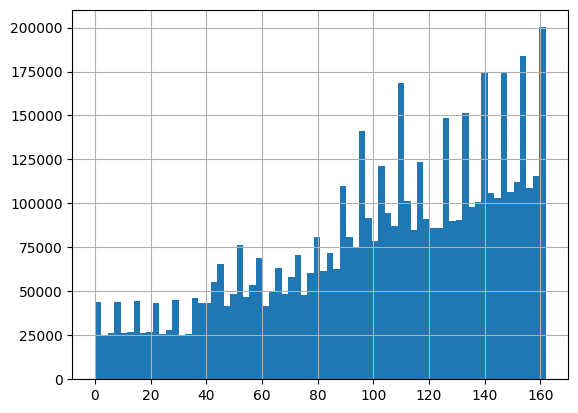

In [6]:
df.last_watch_dt.hist(bins=70)

In [7]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users) #пересечения уникальных пользовательских идентификаторов между `train_users` и `test_users`

print('число людей и в train и в test: ', all_included.shape[0]) # пересечений
print('число людей всего в train:', train_users.shape[0]) 

число людей и в train и в test:  134670
число людей всего в train: 880449


In [8]:
all_included

array([      3,       9,      17, ..., 1097521, 1097525, 1097544],
      dtype=int64)

In [9]:
len(set(test_users) - set(train_users)) / len(test_users) #уникальных пользователей из множества test_users, которые отсутствуют в множестве train_users.
#доля пользователей, которые есть только в тестовом наборе.

0.37768022181146027

In [10]:
len(set(train_users) - set(test_users)) / len(train_users) # доля пользователей, которые есть только в train

0.8470439514384138

И переведём всё к соединённому датасету

In [11]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy() # уникальных пользователей из массива `all_included` без повторений.
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy() 

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min() # максимальная дата в тренировочном наборе меньше минимальной даты в тестовом наборе
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [12]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
28,81786,2616,133,41422,90.0
73,820464,3071,35,4708,80.0
123,514235,8391,147,3570,57.0
139,447592,1241,126,127,3.0
187,138337,11134,145,614,14.0


In [14]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])] ).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)
#  train_df группируется по 'user_id', после чего для каждой группы для каждого пользователя создается 
# список кортежей (t1, t2), где t1 - это значение 'item_id', а t2 - значение 'last_watch_dt', отсортированные по возрастанию даты
test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])] ).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)
#сводные таблицы для тренировочного и тестового наборов данных, содержащие отсортированные интеракции пользователей с товарами по времени просмотра!!!
train_grouped.head()

,user_id,train_interactions
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161..."
1,119,"[(9728, 134), (4436, 135)]"
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460..."
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99..."


In [15]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158..."
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]"
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]"
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]"


In [16]:
np.random.seed(777)

class Random:
    """ 
    Служит для предсказания topn случайных элементов из обученной модели для каждой строки DataFrame, 
    где каждая строка представляет пользователя или сущность, для которой формируются рекомендации
    """

    def __init__(self): # метод-конструктор

        self.trained = False

    def fit(self, df, col='train_interactions'):
        """
        извлекает уникальные элементы из списка интераций в этом столбце и сохраняет их в объекте класса Random.
        """
        items = set()
        for _, row in df.iterrows(): # итерация по строкам 
            for item, _ in row[col]: # Для каждой строки извлекается столбец col, содержащий список кортежей 
                #(например, [(item1, time1), (item2, time2), ...]), итерируется по этому списку.
                items.add(item) # Каждый элемент item из кортежей добавляется во множество items.

        self.items = list(items) # все уникальные элементы(запросы) сохраняются в виде списка в атрибуте items объекта класса Random.
        self.trained = True

    def predict(self, df, topn=10):
        """
        Параметр topn, который определяет количество элементов для предсказания.
        Этот метод возвращает список случайно выбранных элементов из сохраненного списка items.
        """
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df) #  для случайного выбора topn элементов из списка self.items без повторений (replace=False)
                                                                                # затем повторяем len(df) раз


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[12325, 13290, 13609]"
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[12325, 13290, 13609]"
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734...","[12325, 13290, 13609]"
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[12325, 13290, 13609]"
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[12325, 13290, 13609]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$

------------------------------------------------------------------------------------------------------------------

Для вычисления Average Precision (AP) нужно выполнить следующие шаги:
1. **Оценить релевантность предсказаний:**
   - На основе истинных значений и предсказаний оценить, какие из предсказанных элементов являются "верными" релевантными элементами.

2. **Вычислить Precision at k и Average Precision:**
   - Для каждого элемента рассчитать Precision at k (precision@k) до k-го элемента (если не задано, то до конца списка).
   - Average Precision - усредненное значение precision на каждом шаге, где оценено, как много "верных" элементов найдено на момент каждого шага.

In [17]:
from typing import List, Optional
import numpy as np
##Average Precision (AP) TEST TEST TEST TEST TEST 
# def ap_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

#     if topn is not None: 
#         predictions = np.array(predictions[:topn]) # первые topn предсказания

#     num_hits = 0
#     score = 0.0
#     for i, p in enumerate(predictions):
#         if p in gt_items and p not in predictions[:i]:
#             num_hits += 1
#             score += num_hits / (i + 1)

#     # if not gt_items:
#     #     return 0.0
#     avg_precision = score / min(len(gt_items), len(predictions))
#     return avg_precision
# # Пример использования
# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 3  # Если хотим оценить до первых трех предсказаний
# ap = ap_metric(gt_items, predictions, topn)
# print(ap)


In [111]:
from typing import List, Optional
import numpy as np

def ap_metric(gt_items: List[int], predictions: List[int], topn: Optional[int] = None):
    
    if topn is not None:
        predictions = np.array(predictions[:topn])  

    # Создание маски для проверки наличия предиктов среди правильных значений
    correct_mask = np.in1d(predictions, gt_items, assume_unique=True)
    
    # Вычисление накопленной суммы корректных предиктов до каждой позиции
    cumulative_hits = np.cumsum(correct_mask)
    
    # Число позиций для каждого предикта
    positions = np.arange(1, len(predictions) + 1)
    
    # Вычисление precision at k
    precision_at_k = cumulative_hits / positions
    
    # Расчет среднего precision
    avg_precision = 0.0
    count_relevant = min(len(gt_items), len(predictions))
    
    if count_relevant > 0:
        avg_precision = np.sum(precision_at_k * correct_mask) / count_relevant

    return avg_precision

# Пример использования
gt_items = np.asarray([2, 4, 5, 10])
predictions = np.asarray([1, 2, 3, 4, 5])
topn = 2  # Если хотим оценить до первых трех предсказаний
ap = ap_metric(gt_items, predictions, topn)
print(ap)

0.4


1. Reciprocal Rank at k (RR@k):
    - Это метрика, которая оценивает способность модели предсказывать релевантные элементы, инвертируя позицию первого релевантного элемента среди первых k предсказаний.
    - Формула для RR@k: RR@k = 1/(rank_i@k)
    - Здесь rank_i@k - это позиция первого релевантного элемента среди первых k предсказаний.

Например, если для конкретного пользователя первый релевантный элемент находится на третьей позиции среди первых k предсказаний, то RR@k будет равняться 1/3 = 0.33. Чем ближе значение RR@k к 1, тем лучше модель способна предсказывать релевантные элементы раньше.

RR@k полезно использовать как метрику эффективности модели в задачах рекомендаций, поскольку она фокусируется не только на том, насколько верный сам предсказанный элемент, но и на его ранжировании среди остальных предсказаний.

RR отражает, как скоро в среднем мы сможем найти релевантный элемент для каждого пользователя на первых K позициях. Это подчеркивает важность правильной позиции в начале списка.

In [19]:
# def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None): 
#     if topn is None:
#         predictions = predictions[:topn]

#     rr_score = 0.0 
    
#     if gt_items[0] != predictions[0] and topn == 1:
#         return rr_score
    
#     for idx, p in enumerate(predictions):
#         if p in gt_items:
#             rr_score = 1 / (idx + 1)
#             break
    
#     return rr_score

# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 1  # Если хотим оценить до первых трех предсказаний
# rr = rr_metric(gt_items, predictions, topn)
# print(rr)

In [118]:
# векторизовал..
def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None): 
    
    if topn is None:
        predictions = np.array(predictions[:topn])

    rr_score = 0.0

    relevant_indices = np.where(np.in1d(predictions, gt_items))[0]  

    if len(relevant_indices) > 0:
        first_relevant_indices = relevant_indices[0]

        rr_score = 1 / (first_relevant_indices + 1)

    if topn == 1 and gt_items[0] != predictions[0]:
        rr_score = 0.0

    return rr_score


gt_items = np.asarray([2, 4, 5, 10])
predictions = np.asarray([1, 2, 3, 4, 5])
topn = 1  # Если хотим оценить до первых трех предсказаний
rr = rr_metric(gt_items, predictions, topn)
print(rr)

0.0


Hit Rate (HR). Hit Rate - это метрика, которая показывает, есть ли хотя бы один релевантный элемент среди первых $k$ предсказаний.

In [21]:
# def hr_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

#     if topn is None:
#         predictions = predictions[:topn]

#     hr_score = 0.0

#     if gt_items[0] != predictions[0] and topn == 1:
#         return hr_score

#     for idx, p in enumerate(predictions):
#         if p in gt_items:
#             hr_score = 1
#             break 
    

#     return hr_score

# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 3  # Если хотим оценить до первых трех предсказаний
# rr = hr_metric(gt_items, predictions, topn)
# print(rr)

In [120]:
def hr_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

    if topn is None:
        predictions = predictions[:topn]

    hr_score = 0

    hr_score =  int(np.any(np.in1d(predictions, gt_items)))

    if topn == 1 and gt_items[0] != predictions[0]:
        hr_score = 0.0

    return hr_score

gt_items = [1, 2, 3, 4, 5]
predictions = [6, 4, 1, 7, 5]
topn = 3  # Если хотим оценить до первых трех предсказаний
rr = hr_metric(gt_items, predictions, topn)
print(rr)


1


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить из не стоит, разумеется

In [121]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать

In [24]:
def evaluate_recommender(df, model_preds:str , gt_col='test_interactions'):
    """
    model_preds: в нашем случае это название столбца в предсказаниями
    gt_col: столбец тестовых взаимодействий 
    """

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]] # извлекаются gt_items и predictions из строк данных
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions) # Average Precision
        rr = rr_metric(gt_items, predictions) # Reciprocal Rank
        hr = hr_metric(gt_items, predictions) # Hit Rate 

        metric_values.append((ap, rr, hr))
            # усреднили метрики 
    return {'MAP': np.mean([x[0] for x in metric_values]), 
            'MRR': np.mean([x[1] for x in metric_values]),
            'HR': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое

In [25]:
evaluate_recommender(joined, model_preds='random_recs')

{'MAP': 0.00015, 'MRR': 0.00035, 'HR': 0.0007}

In [26]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        # для каждой строки df идет подсчет количества взаимодействий с каждым элементом 
        for _, row in df.iterrows(): # idx, row 
            for item, _ in row[col]: # проверка вхождений в строке row столбца col //   [(item1, _), (item2, _), ]
                if item in counts: 
                    counts[item] += 1
                else:
                    counts[item] = 1
        # сортируем по убыванию кол-во взаимодействий 
        counts_sort = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts_sort] # кортежи (элемент, кол-во взаимодейтсвий)
        self.trained = True

    def predict(self, df, topn=20)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df) # возвращается список списоков, каждый из которых содержит по topn рекомендаций для каждой строки df


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны дать сильно получше

In [27]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'MAP': 0.07360497149365786, 'MRR': 0.1310730234041844, 'HR': 0.3836}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что вне его пределов, учитывать не надо

In [28]:
from datetime import datetime

class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):

        
        super().__init__()
        self.trained = False
        self.min_window = min_window # я так понимаю это количество месяцев // размер окна 

    def fit_window(self, df, col='train_interactions'):
        counts_window = {}
        #определим начало и конец временного окна 
        # end_date = datetime.now().timetuple().tm_yday # текущий день с начала года 

        
        # start_date = end_date - self.min_window * 30 # грубо 

        for _, row in df.iterrows():
            for item, date in row[col]:
                # фильтрация по дате 
                if 0 < date <= self.min_window * 30:
                    if item in counts_window:
                        counts_window[item] += 1
                    else:
                        counts_window[item] = 1
        
        
        counts_window_sort = sorted(counts_window.items(), key=lambda x: x[1], reverse=True)

        self.recommenations_window = [x[0] for x in counts_window_sort]
        self.trained = True

    def predict_window(self, df, topn=20):

        assert self.trained
        return [self.recommenations_window[:topn]]*len(df)

toppopW_test = TopPopularWeighted(min_window=4)
toppopW_test.fit_window(joined)

joined['toppopular_recs_window'] = toppopW_test.predict_window(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_window
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."


In [29]:
evaluate_recommender(joined, 'toppopular_recs_window')

{'MAP': 0.06593785913839806, 'MRR': 0.11970763943014331, 'HR': 0.3212}

Теперь постройте графики зависимости трёх метрик от размера окна

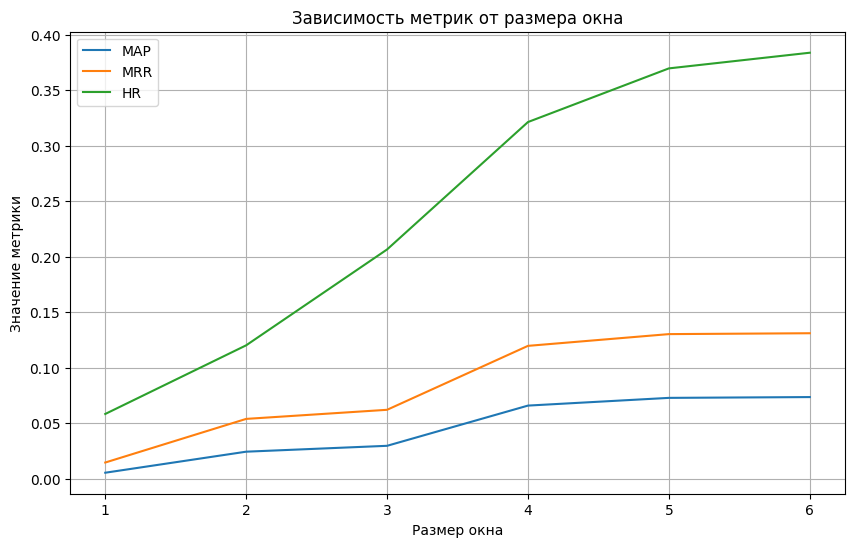

In [30]:
import matplotlib.pyplot as plt

# Размеры окон для анализа
window_sizes = [1, 2, 3, 4, 5, 6]

# Списки для хранения значений метрик
map_values = []
mrr_values = []
hr_values = []

# Проходим по каждому размеру окна
for window_size in window_sizes:
    toppopW = TopPopularWeighted(min_window=window_size)
    toppopW.fit_window(joined)
    joined['toppopular_recs_window'] = toppopW.predict_window(joined)
    metrics = evaluate_recommender(joined, 'toppopular_recs_window')
    
    # Сохраняем значения метрик
    map_values.append(metrics['MAP'])
    mrr_values.append(metrics['MRR'])
    hr_values.append(metrics['HR'])

# Построение графиков
plt.figure(figsize=(10, 6))

plt.plot(window_sizes, map_values, label='MAP') 
plt.plot(window_sizes, mrr_values, label='MRR')
plt.plot(window_sizes, hr_values, label='HR')

plt.xlabel('Размер окна')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от размера окна')
plt.legend()
plt.grid(True)
plt.show()

Подумайте и ответьте, как окно влияет на качество. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** окно однозначно влияет на результат. Во-первых, из графика видно, что чем больше окно, тем лучше результат метрика, и во-вторых, читсо из логических рассуждений, чем больше окно, тем больше сведений о покупателях, тем лучше информация при предсказании(следовательно, лучше метрики)

**Задание №3. Метрики и k.**

Постройте зависимости MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на графике

In [31]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

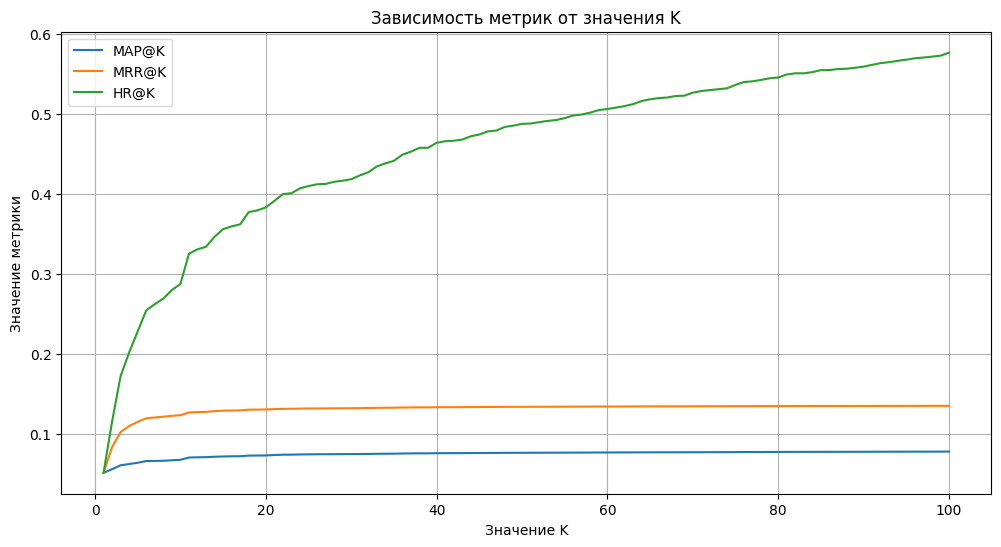

In [32]:
# Значения K от 1 до 100
K_values = list(range(1, 101))

# Списки для хранения значений метрик
map_values = []
mrr_values = []
hr_values = []

# Перебор значений K
for k in K_values:
    toppop = TopPopular()
    toppop.fit(joined)
    joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    
    metrics = evaluate_recommender(joined, 'toppopular_recs')
    
    # Добавление значений метрик
    map_values.append(metrics['MAP'])
    mrr_values.append(metrics['MRR'])
    hr_values.append(metrics['HR'])

# Построение графиков
plt.figure(figsize=(12, 6))

plt.plot(K_values, map_values, label='MAP@K')
plt.plot(K_values, mrr_values, label='MRR@K')
plt.plot(K_values, hr_values, label='HR@K')

plt.xlabel('Значение K')
plt.ylabel('Значение метрики')
plt.title('Зависимость метрик от значения K')
plt.legend()
plt.grid(True)
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** 
- Reciprocal Rank(RR) является монотонной функцией по top-k. С увеличением K, RR будет увеличиваться, поскольку он учитывает только позицию первого релевантного элемента и чем больше элементов смотрится (больший K), тем вероятнее, что найдется релевантный элемент в первых K предсказаниях.

- Hit Rate измеряет, был ли хотя бы один релевантный элемент среди первых K предсказаний. Поэтому с увеличением K, HR@K обычно увеличивается, поскольку шансы на нахождение хотя бы одного релевантного элемента в первых K предсказаниях повышаются. Таким образом, HR@K следует монотонному возрастанию при увеличении значения K. 

- Из графика видно, что как будто бы MAP монотонная, но это не всегда так... MAP@K измеряет среднюю точность прогнозов на первых K позициях, учитывая точность всех предсказаний и их порядок. При увеличении K, модель предоставляет больше предсказаний, что может повлиять на точность и порядок выдачи. В случаях, когда новые предсказания менее точны, чем уже существующие, MAP@K может сначала возрасти, а затем упасть. 

Объясните по каждой метрике, как можно интерпретировать ее график? То есть что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например скроллингом ленты новостей. \
**Ответ:**
- MAP@K (Mean Average Precision at K): График MAP@K показывает среднюю точность рекомендаций для топ-K элементов. Повышение значения говорит о том, что средняя точность увеличивается с увеличением числа элементов в топ-K.

- MRR@K (Mean Reciprocal Rank at K): График MRR@K отражает среднюю обратную позицию первого релевантного элемента среди топ-K предсказаний. Увеличение значения на графике означает улучшение позиции первого релевантного элемента с увеличением числа предсказаний.

- HR@K (Hit Rate at K): График HR@K показывает долю случаев, когда хотя бы один релевантный элемент есть среди топ-K предсказаний. Рост значения говорит о более успешном нахождении хотя бы одного релевантного элемента в топ-K предсказаниях

Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Может помочь поанализировать данные)\
**Ответ:**
- Графики этих метрик обычно должны быть монотонно возрастающими по функции top-K для моделей рекомендаций. Это означает, что увеличение значения K должно приводить к повышению метрик. Однако, иногда могут быть локальные падения или всплески, в зависимости от особенностей данных, модели или алгоритма рекомендации

**Задание №4. Интерпретация рейтингов**

Теперь возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения попуряности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей

In [33]:
items = pd.read_csv('./data/items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

Название фильма: Маленький воин


<Axes: >

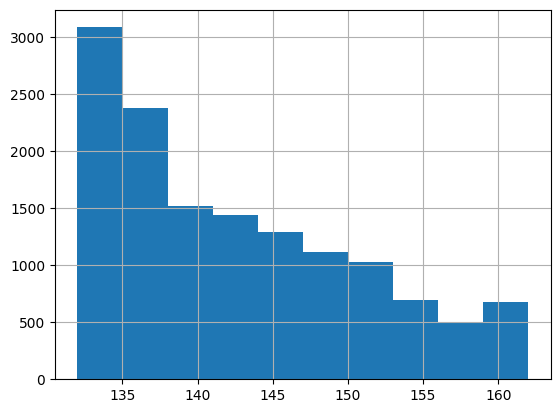

In [34]:
popular_items = df.item_id.value_counts()[:300].index.tolist() # 300 самых популярных items //Функция value_counts() подсчитывает уникальные значения и их частоту
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3784
# выбираются все взаимодействия (строки) из DataFrame df, где item_id соответствует sampled_id
interactions = df.loc[df.item_id==sampled_id].copy()
interactions.head()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма: {name}')
interactions.last_watch_dt.hist()

Фильм Маленький воин был набирал популярность какое-то время, потом видим резкое падение (с какой даты, кстати?). Возможно связано с ограничением доступности к этому фильму, однако не всем участникам, либо же это период проката фильмы / рекламной кампании, и т.д.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали

In [35]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
598,182977,3784,133,4163,82.0
619,72137,3784,138,6,0.0
770,785150,3784,143,6190,100.0
1086,1063946,3784,156,20442,100.0
1295,889595,3784,136,2269,45.0


ПРИМЕР №1 Анализ продолжительности просмотров 

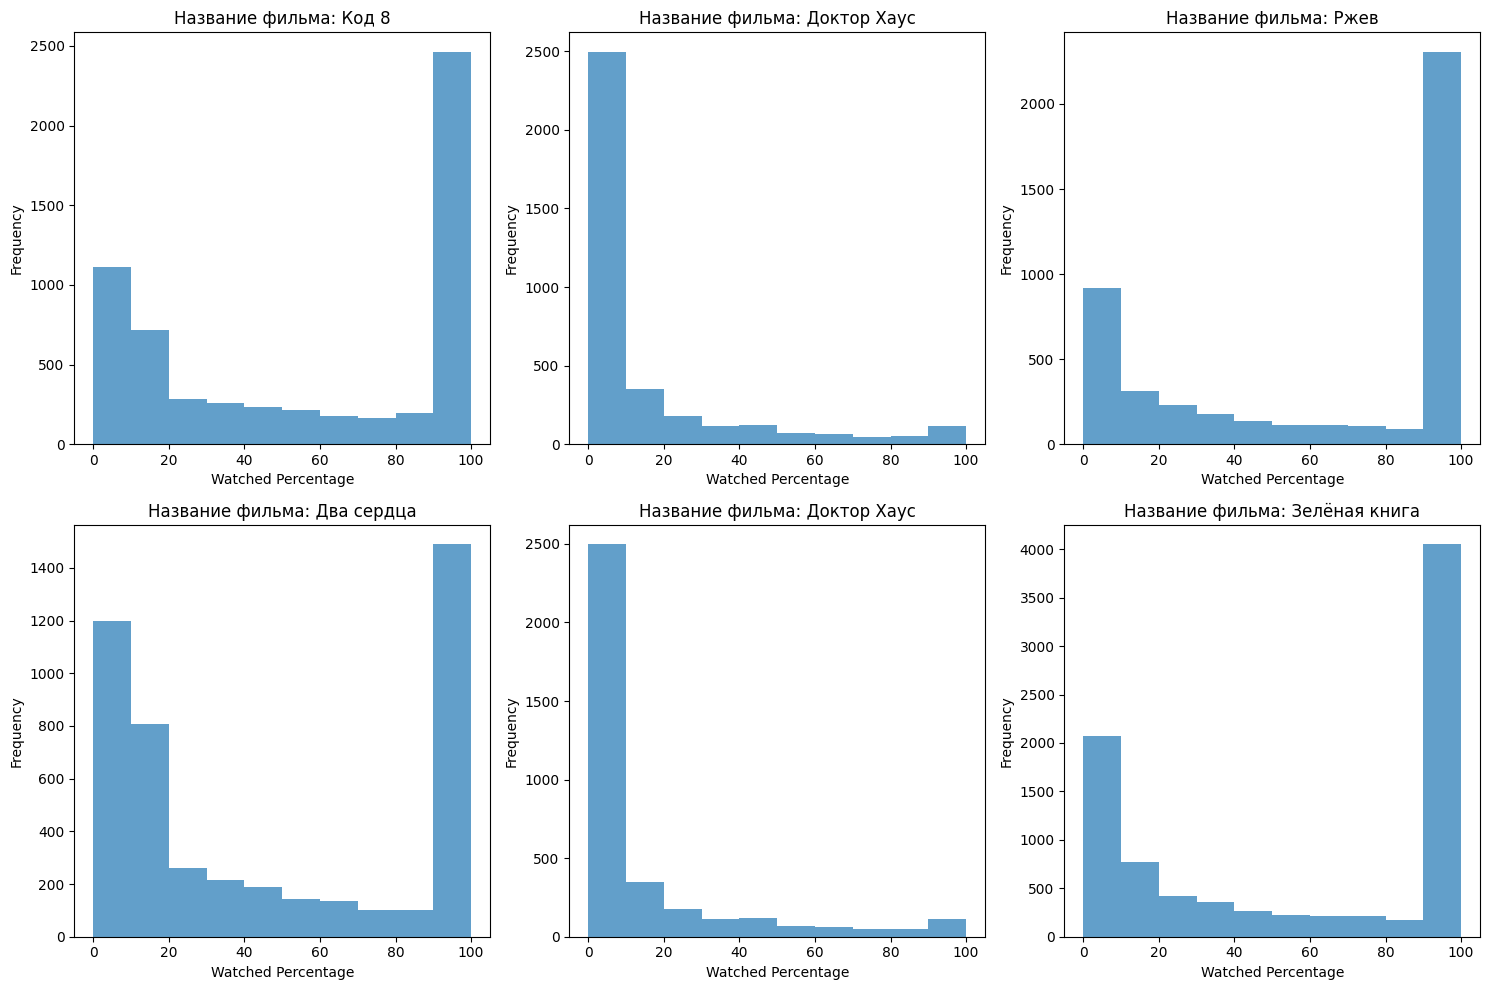

In [36]:
plt.figure(figsize=(15, 10))  


for i in range(6):
    plt.subplot(2, 3, i+1)
    
    popular_items = df.item_id.value_counts()[:300].index.tolist()
    sampled_id = np.random.choice(popular_items)

    interactions = df.loc[df.item_id==sampled_id].copy()
    name = items.loc[items.item_id==sampled_id].title.values[0]
    plt.hist(interactions.watched_pct, bins=10, alpha=0.7)  # Строим гистограмму для watched_pct
    plt.title(f'Название фильма: {name}')  
    plt.xlabel('Watched Percentage')
    plt.ylabel('Frequency')

plt.tight_layout()  # Для улучшения отображения подписей
plt.show()  

По данным гистограмма, можно сдлеать вывод, что в основном фильмы/сериалы или начинают смотреть и почти сразу же заканчивают(по какой либо причине. Например, не понравился и т.д.) или смотрят полностью

ПРИМЕР №2 анализа сезонности просмотров

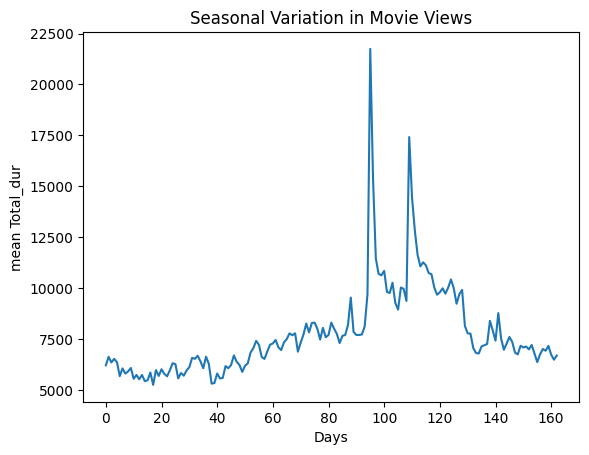

In [37]:
monthly_views = df.groupby(df['last_watch_dt'])['total_dur'].mean()
plt.plot(monthly_views)
plt.xlabel('Days')
plt.ylabel('mean Total_dur') #  средняя общая продолжительность всех просмотров данного контента в секундах
plt.title('Seasonal Variation in Movie Views')
plt.show()

Данные по просмотру контента собраны за ~6 месяцев, с 2021-03-13 по 2021-08-22  включительно. Видно, что с началом лета Общая продолжительность всех просмотров данного контента в секундах имеет резкий пик. А именно два пика с началом июня и июля. Это связано с тем, что у многих школьников/студентов в это время начинаются каникулы, а у взрослых отпуска.

ПРИМЕР №3 Сезонные колебания

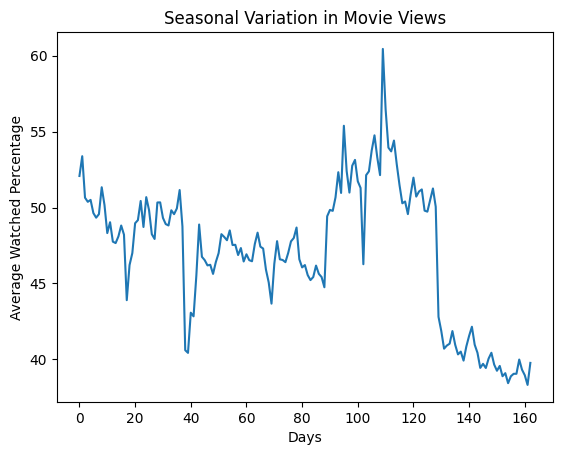

In [38]:
monthly_views = df.groupby(df['last_watch_dt'])['watched_pct'].mean()
plt.plot(monthly_views)
plt.xlabel('Days')
plt.ylabel('Average Watched Percentage')
plt.title('Seasonal Variation in Movie Views')
plt.show()

Данная зависимость также характеризует сезонность продолжительности просмотров. Видно, что с окончанием лета(Данные по просмотру контента собраны за ~6 месяцев, с 2021-03-13 по 2021-08-22  включительно) продолжительность просмотров резко падает, из-за начала учебного года/ конца отпусков и т.д.

ПРИМЕР №4 зависимость среднего времени последнего просмотра контента от процента просмотра (watched_pct)

Название фильма: Донбасс. Окраина


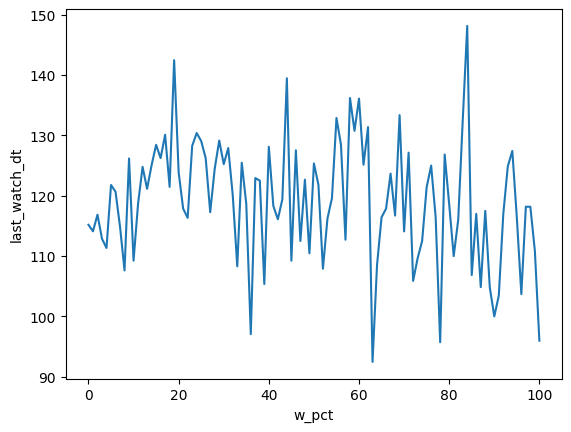

In [39]:
popular_items = df.item_id.value_counts()[:300].index.tolist() # 300 самых популярных items //Функция value_counts() подсчитывает уникальные значения и их частоту
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
# выбираются все взаимодействия (строки) из DataFrame df, где item_id соответствует sampled_id
interactions = df.loc[df.item_id==sampled_id].copy()
interactions.head()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма: {name}')

monthly_views = interactions.groupby(interactions['watched_pct'])['last_watch_dt'].mean()
plt.plot(monthly_views) # ОТФИЛЬТРОВАТЬ ПО ФИЛЬМУ 
plt.xlabel('w_pct')
plt.ylabel('last_watch_dt') #  средняя общая продолжительность всех просмотров данного контента в секундах
plt.show()

Стабильность: Если среднее время последнего просмотра остается примерно одинаковым независимо от процента просмотра, это может указывать на стабильный интерес к контенту со временем. В этом случае можно предположить, что контент имеет постоянную аудитрию.

**Задание №5. User-item encoding**

Теперь создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить sparse matrix, в которой в качестве строк будут пользователи, в качестве колонок айтемы. Не забудьте закодировать пользователей и айтемы к "внутренней кодировке". В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас второе условие на минимальное число интеракций с айтемом перестанет выполняться. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это может нарушить снова условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока в обоих колонках не будет выполняться требование

In [40]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and lest popular items.
    Should return copy of the dataframe with at least min_freq entries
    in both users and items
    """
    filtered_df = df.copy()
    user_counts = df['user_id'].value_counts() # {user : кол-во (популярность)}
    item_counts = df['item_id'].value_counts()
    # фильтруем 
    filtered_df  = filtered_df[df['user_id'].isin(user_counts[user_counts >= min_freq].index)] 
    filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]

    return filtered_df 


def filter_dataframe(df, cols, min_freq=4): 
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Should return copy
    of the dataframe
    """
    filtered_df = df.copy()
    for col in cols:
        filtered_df = filter_column(filtered_df, min_freq)

    
    return filtered_df

In [57]:
filtered_train = filter_dataframe(df, ['user_id', 'item_id'], 25)
filtered_train.head(), filtered_train.shape

C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]


(    user_id  item_id  last_watch_dt  total_dur  watched_pct
 0    176549     9506             59       4250         72.0
 1    699317     1659             77       8317        100.0
 6   1016458      354            154       1672         25.0
 14     5324     8437             36       6598         92.0
 18   927973     9617             98       8422        100.0,
 (1603997, 5))

In [59]:
# def df_encode(df):
#     df = df.copy()
#     item2id = {k:v for v, k in enumerate(df.item_id.unique())}
#     user2id = {k:v for v, k in enumerate(df.user_id.unique())}

#     id2item = {k:v for v, k in item2id.items()}
#     id2user = {k:v for v, k in user2id.items()}

#     df['user_id'] = df.user_id.apply(lambda x: user2id[x])
#     df['item_id'] = df.item_id.apply(lambda x: item2id[x])
#     return df

# filtered_train_encode = df_encode(filtered_train)
# filtered_train_encode.head(), filtered_train_encode.sample(5), filtered_train_encode.shape

(    user_id  item_id  last_watch_dt  total_dur  watched_pct
 0         0        0             59       4250         72.0
 1         1        1             77       8317        100.0
 6         2        2            154       1672         25.0
 14        3        3             36       6598         92.0
 18        4        4             98       8422        100.0,
          user_id  item_id  last_watch_dt  total_dur  watched_pct
 3512809     3692     3124            162        409          7.0
 4314427    17762      196             99          7          0.0
 1665644    16257     1029             64        128          2.0
 2615484    35860       92            136       5780         92.0
 604817     28067      693             79       7578        100.0,
 (1603997, 5))

Матрицу интеракций user-item 

In [161]:
df_user_item_filtered = filtered_train[['user_id', 'item_id']]
df_user_item_filtered.head()

,user_id,item_id
0,176549,9506
1,699317,1659
6,1016458,354
14,5324,8437
18,927973,9617


In [162]:
from scipy.sparse import csr_matrix
import pandas as pd
from sklearn.preprocessing import LabelEncoder
#Кодирование пользователей и айтемов к "внутренней кодировке"

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

user_encoder.fit(df_user_item_filtered['user_id'])
item_encoder.fit(df_user_item_filtered['item_id'])

df_user_item_filtered['user_encoded'] = user_encoder.transform(df_user_item_filtered['user_id'])
df_user_item_filtered['item_encoded'] = item_encoder.transform(df_user_item_filtered['item_id'])

# Создание sparse матрицы user-item
num_users = df_user_item_filtered['user_encoded'].nunique()
num_items = df_user_item_filtered['item_encoded'].nunique()

user_item_matrix = csr_matrix((np.ones_like(df_user_item_filtered['user_encoded']), 
                            (df_user_item_filtered['user_encoded'], df_user_item_filtered['item_encoded'])), 
                            shape=(num_users, num_items))

user_item_matrix.toarray(), user_item_matrix.shape

C:\Users\master\AppData\Local\Temp\ipykernel_15116\4084846098.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_item_filtered['user_encoded'] = user_encoder.transform(df_user_item_filtered['user_id'])
C:\Users\master\AppData\Local\Temp\ipykernel_15116\4084846098.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user_item_filtered['item_encoded'] = item_encoder.transform(df_user_item_filtered['item_id'])


(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0]], dtype=int64),
 (36476, 4964))

In [163]:
user_item_matrix.shape

(36476, 4964)

In [164]:
# from scipy import sparse as sps

# df_encode = filtered_train_encode
item2id = {k:v for v, k in enumerate(df_user_item_filtered.item_id.unique())}
user2id = {k:v for v, k in enumerate(df_user_item_filtered.user_id.unique())}
id2item = {k:v for v, k in item2id.items()}


**Задание №6. Интерации и частота**

Нужно построить график на число айтемов и юзеров, которые остаются в матрице интеракций в зависимости от строгости фильтров на встречаемость. То есть нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра

C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_15116\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_151

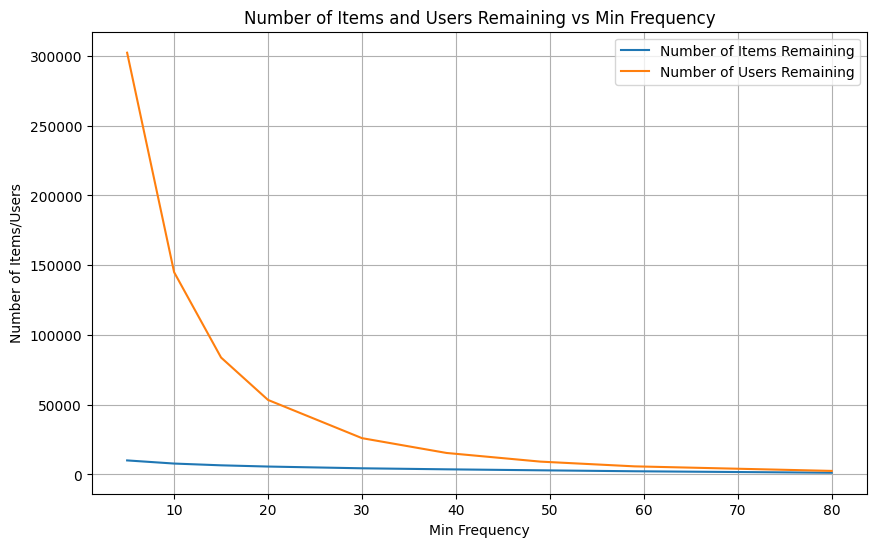

In [167]:
#Различные значения min_freq для анализа
min_freq_values = [5, 10, 15, 20, 30, 39, 49, 59, 80]

num_items_remaining = []
num_users_remaining = []

for min_freq in min_freq_values:
    filtered_df = filter_dataframe(df, ['user_id', 'item_id'], min_freq)
    
    # Создание словарей item2id и user2id
    item2id_plot = {item: idx for idx, item in enumerate(filtered_df['item_id'].unique())}
    user2id_plot = {user: idx for idx, user in enumerate(filtered_df['user_id'].unique())}
    
    
    num_items_remaining.append(len(item2id_plot))
    num_users_remaining.append(len(user2id_plot))

# Построение графика зависимости числа оставшихся айтемов и юзеров от параметра min_freq
plt.figure(figsize=(10, 6))
plt.plot(min_freq_values, num_items_remaining, label='Number of Items Remaining')
plt.plot(min_freq_values, num_users_remaining, label='Number of Users Remaining')
plt.xlabel('Min Frequency')
plt.ylabel('Number of Items/Users')
plt.title('Number of Items and Users Remaining vs Min Frequency')
plt.legend()
plt.grid()
plt.show()
None

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все метрики качества с `TopPopular` для некоторого набора k

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole

In [264]:
import numpy as np
import scipy.sparse as sps

def fit_ease(matrix, lambda_reg=20000):
    #  Грам-матрица
    G = matrix.T.dot(matrix)  
    #индексы элементов на диагонали
    diagIndices = np.diag_indices(G.A.shape[0])
    G[diagIndices] += lambda_reg

    #Вычислить обратную Грам-матрицу.
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diagIndices] = 0
    
    return B

In [265]:
# Пример вызова функции fit_ease с матрицей matrix
W = fit_ease(user_item_matrix)
W.shape, W

((4964, 4964),
 array([[ 0.00000000e+00,  4.34578049e-05, -5.03268095e-05, ...,
          2.40158040e-05,  4.17407597e-05, -1.42001250e-06],
        [ 4.34296369e-05,  0.00000000e+00, -2.65435551e-05, ...,
         -2.71574178e-05, -7.90684533e-05, -1.75297707e-06],
        [-4.65344497e-05, -2.45592931e-05,  0.00000000e+00, ...,
          1.27636521e-04,  4.13542268e-03,  8.82718821e-05],
        ...,
        [ 2.31220361e-05, -2.61636907e-05,  1.32901143e-04, ...,
          0.00000000e+00,  1.50966379e-03,  4.72440500e-05],
        [ 3.76665890e-05, -7.13971335e-05,  4.03590251e-03, ...,
          1.41497003e-03,  0.00000000e+00,  1.38108678e-04],
        [-1.41923000e-06, -1.75314742e-06,  9.54130584e-05, ...,
          4.90431990e-05,  1.52962734e-04,  0.00000000e+00]]))

In [218]:
import numpy as np

def get_preds(test_interactions, item2id, id2item, w, topn):
    all_preds = []

    for user_id, item_id in test_interactions:
        user_vector = np.zeros(len(item2id))
        if item_id in item2id:
            user_vector[item2id[item_id]] = 1

        preds = user_vector.dot(w)  # Умножаем на матрицу весов
        
        # Декодируем предсказания
        decoded = [id2item[i] for i in np.argsort(-preds)]
        all_preds.append(decoded[:topn])
    
    return all_preds[0]

In [242]:
x = joined['test_interactions'][1000]
print(x)
preds = get_preds(x, item2id, id2item, W, 20)
print(preds)

[(10515, 153), (7310, 154)]
[9506, 12104, 5138, 14466, 242, 3857, 8216, 15352, 14256, 15876, 9055, 8111, 8606, 1572, 11061, 12567, 4358, 10020, 4590, 13450]


Далее вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя, и умножить его на матрицу весов

In [85]:
joined['ease_preds'] = joined.test_interactions.apply(lambda x: get_preds(x, item2id, id2item, W, 25))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_window,ease_preds
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[519, 387, 59, 1581, 161, 104, 685, 54, 1063, ..."
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[330, 195, 391, 1389, 314, 214, 122, 1366, 603..."
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[519, 387, 59, 1581, 161, 104, 685, 54, 1063, ..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[1897, 11, 1548, 749, 155, 1471, 1853, 685, 15..."
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[155, 950, 460, 401, 169, 762, 1730, 1044, 937..."


In [86]:
evaluate_recommender(joined, model_preds='ease_preds')

{'MAP': 0.00038792053852580163, 'MRR': 0.0008580138222630483, 'HR': 0.003}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**
Судя по метрикам, лучше всего работает алгоритм TopPopular. Но есть предположение, что я неправильно реализовал функцию нахождения матрицы-схожести и функцию предсказания. Пробовал множество вариантов...Но всё равно на всех тестах метрики очень маленькие... 

**Задание №8. Тюнинг**

Теперь проварьируйте параметр регуляризации у EASE и постройте все те же графики, что и в задании №6, только путем варирования различных значениях гиперпараметра коэффициента регуляризации. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации

In [197]:
joined_n = joined.head(1000)

In [198]:
joined_n['ease_preds'] = joined_n.test_interactions.apply(lambda x: get_preds(x, item2id, id2item, W, 20))

C:\Users\master\AppData\Local\Temp\ipykernel_15116\2089766893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joined_n['ease_preds'] = joined_n.test_interactions.apply(lambda x: get_preds(x, item2id, id2item, W, 20))


In [199]:
joined_n.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_window,ease_preds
0,53,"[(13865, 110), (7571, 110), (10440, 115), (161...","[(16426, 155), (1445, 157), (15629, 157), (158...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9506, 12104, 5138, 14466, 242, 3857, 8216, 15..."
1,119,"[(9728, 134), (4436, 135)]","[(4266, 154), (15719, 154), (3999, 154)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9506, 12104, 5138, 14466, 242, 3857, 8216, 15..."
2,144,"[(9728, 126), (13865, 128), (741, 130), (15297...","[(4151, 155), (10942, 157), (8821, 157), (3734...","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9506, 12104, 5138, 14466, 242, 3857, 8216, 15..."
3,229,"[(11275, 110), (4151, 110), (1699, 126), (1460...","[(14910, 153), (10440, 160), (3697, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9506, 12104, 5138, 14466, 242, 3857, 8216, 15..."
4,304,"[(11985, 71), (2301, 71), (175, 75), (4457, 99...","[(6054, 161), (4073, 161)]","[12325, 13290, 13609]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[9506, 12104, 5138, 14466, 242, 3857, 8216, 15..."


In [200]:
evaluate_recommender(joined_n, model_preds='ease_preds', gt_col='test_interactions')

{'MAP': 0.0006445701357466064, 'MRR': 0.003499116569704805, 'HR': 0.01}

In [201]:
import numpy as np
import matplotlib.pyplot as plt

# Создадим логарифмическую сетку значений для параметра регуляризации
lambda_values = np.logspace(-3, 5, num=20)

# Список для хранения результатов
results = []

for lambda_reg in lambda_values:
    # Обучение модели EASE с текущим значением коэффициента регуляризации
    w = fit_ease(user_item_matrix, lambda_reg=lambda_reg)
    
    # Получение предсказаний для тестовых взаимодействий
    joined_n['ease_preds'] = joined_n.test_interactions.apply(lambda x: get_preds(x, item2id, id2item, W, 20))
    
    # Оценка модели и вычисление метрик
    metric_values = evaluate_recommender(joined_n, model_preds='ease_preds', gt_col='test_interactions')
    
    results.append((lambda_reg, metric_values))

# Разделение результатов на значения метрик
MAP_values = [x[1]['MAP'] for x in results]
MRR_values = [x[1]['MRR'] for x in results]
HR_values = [x[1]['HR'] for x in results]

# Построение графиков
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.plot(lambda_values, MAP_values, marker='o')
plt.xscale('log')
plt.title('Mean Average Precision (MAP)')

plt.subplot(2, 2, 2)
plt.plot(lambda_values, MRR_values, marker='o')
plt.xscale('log')
plt.title('Mean Reciprocal Rank (MRR)')

plt.subplot(2, 2, 3)
plt.plot(lambda_values, HR_values, marker='o')
plt.xscale('log')
plt.title('Hit Rate (HR)')

plt.tight_layout()
plt.show()

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'

Ответьте на следующие вопросы:

Какое значение гиперпараметра является наилучшим? \\
**Ответ:**

Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга? \
**Ответ:**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым встречаемости user/item (из задания №6). Сделайте выводы

Важно, в этом задании линии могут быть мало разлимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали отличимыми

Что вы можете сказать по графикам? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов

In [250]:
def get_top_n_recommendations(item_id, item_weights, n=5):
    # Получаем веса для данного айтема
    weights = item_weights[item_id]
    
    # Сортируем индексы по убыванию весов и берем топ-N
    top_indices = np.argsort(weights)[::-1][:n]
    
    return top_indices

In [267]:
# Получаем матрицу весов item2item с помощью EASE
item_weights = fit_ease(user_item_matrix)
item_weights

array([[ 0.00000000e+00,  4.34578049e-05, -5.03268095e-05, ...,
         2.40158040e-05,  4.17407597e-05, -1.42001250e-06],
       [ 4.34296369e-05,  0.00000000e+00, -2.65435551e-05, ...,
        -2.71574178e-05, -7.90684533e-05, -1.75297707e-06],
       [-4.65344497e-05, -2.45592931e-05,  0.00000000e+00, ...,
         1.27636521e-04,  4.13542268e-03,  8.82718821e-05],
       ...,
       [ 2.31220361e-05, -2.61636907e-05,  1.32901143e-04, ...,
         0.00000000e+00,  1.50966379e-03,  4.72440500e-05],
       [ 3.76665890e-05, -7.13971335e-05,  4.03590251e-03, ...,
         1.41497003e-03,  0.00000000e+00,  1.38108678e-04],
       [-1.41923000e-06, -1.75314742e-06,  9.54130584e-05, ...,
         4.90431990e-05,  1.52962734e-04,  0.00000000e+00]])

In [268]:
top_recommendations = get_top_n_recommendations(10, item_weights, n=5)

In [274]:
# Примеры топ-5 рекомендаций для сэмплируемых айтемов
sample_item_ids = [0, 10, 20, 30, 40]  # Примеры сэмплируемых айтемов

for item_id in sample_item_ids:
    top_recommendations = get_top_n_recommendations(item_id, item_weights, n=5)

    print(f"Для айтема '{item_id}' рекомендуем: //({items['title'][item_id]})")
    for i, rec_id in enumerate(top_recommendations):
        print(f"{i+1}. {items['title'][rec_id]}")
    print()

Для айтема '0' рекомендуем: //(Поговори с ней)
1. Enchantimals: Тайны снежной долины
2. Уедем к чёртовой бабушке
3. Заячья школа
4. Невидимый мир
5. В другой стране

Для айтема '10' рекомендуем: //(Код «Красный»)
1. Неугомонные цыплята
2. [4К] Агатс, столица народа асмат. Западное Папуа
3. Пока тюрьма не разлучит нас
4. Джори
5. Боудика королева воинов

Для айтема '20' рекомендуем: //(Рождество трех медведей)
1. Внеземное эхо
2. Ужин с придурками
3. Так начиналась легенда
4. Камера
5. Зеркало для героя

Для айтема '30' рекомендуем: //(Золушка: Полный вперед!)
1. Сатана
2. Белый медведь, морское млекопитающее. Арктика
3. Охота. Монте-Пердидо
4. Последний раз, когда я видел Париж
5. Сыщик

Для айтема '40' рекомендуем: //(Да здравствует Франция!)
1. Хочу как Бриджит
2. Бобби и Билл
3. Дружок
4. Вивариум
5. Зеленее травы



Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**
-плохие рекомендации могут быть результатом недостаточной корреляции между айтемами в матрице весов item2item.
-Плохие рекомендации могут возникать из-за недостаточного разнообразия данных или недостаточной информации о предпочтениях пользователя.